In [1]:
pip install pywsd

     |████████████████████████████████| 26.8 MB 24.5 MB/s 
     |████████████████████████████████| 31.6 MB 273 kB/s 
  Created wheel for pywsd: filename=pywsd-1.2.4-py3-none-any.whl size=26940452 sha256=d23cb65c7b266808e48c3f10bf0643a1c8dfdcdece33e61c67f99b2b98560877
  Stored in directory: /root/.cache/pip/wheels/56/67/c0/6e6fa8456d1374b393328368316c3b33844cb4043bd225bc66
  Created wheel for wn: filename=wn-0.0.23-py3-none-any.whl size=31792943 sha256=de27be27c5a6f588991ed462d21c3c06d1449e58cea4de1e5e6b6650b5bb5132
  Stored in directory: /root/.cache/pip/wheels/ec/47/17/409766c99dd470f34c512000b90b83f34747c2c975769654d7
Successfully built pywsd wn
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD,PCA
from sklearn.manifold import MDS
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import casual_tokenize
import string
from pywsd.utils import lemmatize_sentence
from sklearn.feature_extraction.text import TfidfVectorizer,ENGLISH_STOP_WORDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import catboost
import os
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Warming up PyWSD (takes ~10 secs)... took 6.618751287460327 secs.


/kaggle/input/coronavirus-covid19-tweets/Countries.CSV
/kaggle/input/coronavirus-tweets/Corona.csv


# Briefly Look at Data

In [3]:
data = pd.read_csv(r'../input/coronavirus-tweets/Corona.csv')

In [4]:
data.head(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


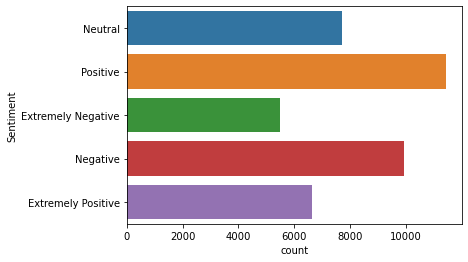

In [5]:
tweets_raw = data['OriginalTweet']
sns.countplot(y=data['Sentiment']);

# Data Preparation Pipeline: 
# Removing References -> Lower Cse -> Lemmatizing -> Removing Punctuation,Stop Words -> Vectorizing

# Removing the References

In [6]:
tweets = tweets_raw.apply(lambda x: re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str(x)))
tweets.head(5)

0           @MeNyrbie @Phil_Gahan @Chrisitv  and  and 
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
Name: OriginalTweet, dtype: object

# To Lower Case

In [7]:
tweets = tweets.apply(lambda x : x.lower())
tweets.head(5)

0           @menyrbie @phil_gahan @chrisitv  and  and 
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
3    my food stock is not the only one which is emp...
4    me, ready to go at supermarket during the #cov...
Name: OriginalTweet, dtype: object

# Lemmatizing

In [8]:
tweets_lemmatized = tweets.apply(lambda x : lemmatize_sentence(x))
tweets = tweets_lemmatized.apply(lambda x: ' '.join(x))
tweets.head(5)

0           @ menyrbie @ phil_gahan @ chrisitv and and
1    advice talk to your neighbour family to exchan...
2    coronavirus australia : woolworth to give elde...
3    my food stock be not the only one which be emp...
4    me , ready to go at supermarket during the # c...
Name: OriginalTweet, dtype: object

# Punctuation

In [9]:
Punctuation = string.punctuation

# Removing Stop-Words and Punctuation

In [10]:
ENGLISH_STOP_WORDS_PUNCTUATION = list(ENGLISH_STOP_WORDS)
for i in Punctuation:
    ENGLISH_STOP_WORDS_PUNCTUATION.append(i)
    
corona_Stop =[ '#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19',
'#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19','. .',
 '. . .',
 '. . . . .',
 '..',
 '...',
 '... .',
 '... ..',
 '... ...',
 '... ... .',
 '0',
 '00',
 '000',
 '1',
 '1,000',
 '1.5',
 '1/2',
 '1/3',
 '10',
 '10,000',
 '100',
'100,000',
 '1000',
 '101',
 '10downingstreet',
 '11',
 '12',
 '13',
 '14',
 '15',
 '150',
 '16',
 '17',
 '18',
 '19',
 '19au',
 '19aus',
 '19australia',
 '19canada',
 '19india',
 '19nz',
 '19on',
 '19out',
 '19outbreak',
 '19pandemic',
 '19sa',
 '19southafrica',
 '19th',
 '19ug',
 '19uk',
 '19us',
 '19usa',
 '1st',
 '2',
 '2-3',
 '2.italy',
 '2/2',
 '20',
 '200',
 '2000',
 '2003',
 '2008',
 '2016',
 '2018',
 '2019',
 '2019au',
 '2020',
 '2021',
 '21',
 '21daylockdown',
 '21dayslockdown',
 '22',
 '23',
 '24',
 '\x92',
 '24/7',
 '25',
 '26',
 '27',
 '28',
 '2m',
 '2nd',
 '2x',
 '3',
 '3.wuhan',
 '30',
 '300',
 '31',
 '32',
 '33',
 '34',
 '35',
 '35,000',
 '36',
 '37',
 '3d',
 '3m',
 '3rd',
 '4',
 '40',
 '400',
 '42',
 '43',
 '45',
 '48',
 '4all',
 '4th',
 '5',
 '50',
 '500',
 '55',
 '5g',
 '6',
 '60',
 '600',
 '65',
 '66',
 '6am',
 '6ft',
 '7',
 '70',
 '700',
 '71',
 '72',
 '75',
 '77',
 '7am',
 '7news',
 '8',
 '80',
 '800',
 '85',
 '8am',
 '8p',
 '9',
 '90',
 '900',
 '95',
 '99',
 '9am',
 '_19',
 '_19uk',
 '__19' ]

for i in corona_Stop:
    ENGLISH_STOP_WORDS_PUNCTUATION.append(i)

# Vectorizing
In order to compare accuracy, 4 vector representations were created: unigrams, bigrams, threegrams and 1-3grams

In [11]:
vectorizer = TfidfVectorizer(lowercase=True,
                             stop_words=ENGLISH_STOP_WORDS_PUNCTUATION,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65)

vectorizer_bigrams = TfidfVectorizer(lowercase=True,
                             stop_words=ENGLISH_STOP_WORDS_PUNCTUATION,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65,
                            ngram_range=(2,2))

vectorizer_threegrams = TfidfVectorizer(lowercase=True,
                             stop_words=ENGLISH_STOP_WORDS_PUNCTUATION,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65,
                            ngram_range=(3,3))

vectorizer_13 = TfidfVectorizer(lowercase=True,
                             stop_words=ENGLISH_STOP_WORDS_PUNCTUATION,
                            tokenizer = casual_tokenize,
                            min_df = 0.0004,
                            max_df=0.65,
                            ngram_range=(1,3))

representation = vectorizer.fit_transform(tweets).toarray()
representation2 = vectorizer_bigrams.fit_transform(tweets).toarray()
representation3 = vectorizer_threegrams.fit_transform(tweets).toarray()
representation13 = vectorizer_13.fit_transform(tweets).toarray()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#coronaviruspandemic', 'covid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#coronaviruspandemic', 'covid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['#coronaviruspandemic', 'covid'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with 

In [12]:
vectorizer.get_feature_names()

['abc',
 'abcnews',
 'ability',
 'able',
 'absolute',
 'absolutely',
 'absurd',
 'abt',
 'abuse',
 'accelerate',
 'accept',
 'access',
 'accessible',
 'accommodation',
 'accord',
 'account',
 'accurate',
 'accuse',
 'achieve',
 'acquire',
 'act',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'actually',
 'ad',
 'adapt',
 'add',
 'addition',
 'additional',
 'additive',
 'address',
 'adequate',
 'adhere',
 'adjust',
 'administration',
 'admit',
 'adopt',
 'adult',
 'advance',
 'advantage',
 'adventure',
 'advertise',
 'advertising',
 'advice',
 'advise',
 'advisory',
 'advocate',
 'aerosol',
 'affair',
 'affect',
 'affected',
 'afford',
 'affordable',
 'afloat',
 'afraid',
 'africa',
 'african',
 'aftermath',
 'afternoon',
 'ag',
 'age',
 'agency',
 'agent',
 'ago',
 'agree',
 'agreement',
 'agricultural',
 'agriculture',
 'ahead',
 'ai',
 'aid',
 'aim',
 'ain',
 'air',
 'airborne',
 'airline',
 'airport',
 'aisle',
 'aka',
 'al',
 'alarm',
 'alberta',
 'albertson

In [13]:
vectorizer_bigrams.get_feature_names()

['able buy',
 'access food',
 'act like',
 'actually need',
 'advantage covid',
 'advantage fear',
 'advantage situation',
 'affect covid',
 'afford stock',
 'affordable price',
 'age covid',
 'agree cut',
 "ai n't",
 'ain t',
 'air long',
 'aisle supermarket',
 'alcohol base',
 'alert giveawayalert',
 'allow people',
 'amazon covid',
 'amazon hire',
 'america s',
 'american consumer',
 'amid covid',
 'amid crisis',
 'amid fear',
 'amid outbreak',
 'amid pandemic',
 'amid panic',
 'amidst covid',
 'answer question',
 'arabia russia',
 'aren t',
 'asda morrison',
 'asda tesco',
 'ask people',
 'ask question',
 'asset price',
 'attorney general',
 'australia s',
 'available consumer',
 'avoid covid',
 'avoid crowd',
 'avoid scam',
 'away people',
 'b c',
 'baby formula',
 'bad covid',
 'bad news',
 'bank account',
 'bank pressure',
 'bar restaurant',
 'basic food',
 'basic necessity',
 'battle covid',
 'bay area',
 'bbc news',
 'bc covid',
 'begin die',
 'behavior change',
 'behavior cov

In [14]:
vectorizer_threegrams.get_feature_names()

['advantage fear surround',
 'alert giveawayalert competition',
 'amid covid crisis',
 'amid covid lockdown',
 'amid covid outbreak',
 'amid covid pandemic',
 'amid covid panic',
 'amid panic buying',
 'bottle hand sanitizer',
 'bushcraft rt follow',
 'buy grocery store',
 'buy toilet paper',
 "ca n't afford",
 'care worker grocery',
 'cashier grocery store',
 'change consumer behavior',
 'change consumer behaviour',
 'clear supermarket shelf',
 'close retail store',
 'collapse oil price',
 'come grocery store',
 'competition puzzle join',
 'consumer behavior change',
 'consumer behavior covid',
 'consumer financial protection',
 'consumer protection act',
 'consumer protection law',
 'consumer small business',
 'contest alert giveawayalert',
 'corona coronavirusoutbreak prepper',
 'corona covid covid',
 'coronacrisis stopstockpiling stoppanicbuying',
 'coronavirusoutbreak covid covid',
 'coronavirusoutbreak prepper survival',
 'coronaviruspandemic covid covid',
 'coronavirusupdate cov

In [15]:
vectorizer_13.get_feature_names()

['abc',
 'abcnews',
 'ability',
 'able',
 'able buy',
 'absolute',
 'absolutely',
 'absurd',
 'abt',
 'abuse',
 'accelerate',
 'accept',
 'access',
 'access food',
 'accessible',
 'accommodation',
 'accord',
 'account',
 'accurate',
 'accuse',
 'achieve',
 'acquire',
 'act',
 'act like',
 'action',
 'active',
 'actively',
 'activity',
 'actor',
 'actual',
 'actually',
 'actually need',
 'ad',
 'adapt',
 'add',
 'addition',
 'additional',
 'additive',
 'address',
 'adequate',
 'adhere',
 'adjust',
 'administration',
 'admit',
 'adopt',
 'adult',
 'advance',
 'advantage',
 'advantage covid',
 'advantage fear',
 'advantage fear surround',
 'advantage situation',
 'adventure',
 'advertise',
 'advertising',
 'advice',
 'advise',
 'advisory',
 'advocate',
 'aerosol',
 'affair',
 'affect',
 'affect covid',
 'affected',
 'afford',
 'afford stock',
 'affordable',
 'affordable price',
 'afloat',
 'afraid',
 'africa',
 'african',
 'aftermath',
 'afternoon',
 'ag',
 'age',
 'age covid',
 'agency',

In [16]:
print("unigrams size: ",representation.shape[1])
print("bigrams size: ",representation2.shape[1])
print("threegrams size: ",representation3.shape[1])
print("uni-three grams size: ",representation13.shape[1])

unigrams size:  3664
bigrams size:  2265
threegrams size:  390
uni-three grams size:  6319


# Prepating Test Data

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(representation,
                                                 data['Sentiment'])

x_train2,x_test2,y_train2,y_test2 = train_test_split(representation2,
                                                 data['Sentiment'])

x_train3,x_test3,y_train3,y_test3 = train_test_split(representation3,
                                                 data['Sentiment'])

x_train13,x_test13,y_train13,y_test13 = train_test_split(representation13,
                                                 data['Sentiment'])

# LDA. SVD Solver. Comparing Accuracy on different datasets.
According to result, unigrams showed the best perfomance among all

In [18]:
lda_model_4 = LinearDiscriminantAnalysis(n_components=4).fit(x_train,
                                                             y_train)

lda_model_4_predictions = lda_model_4.predict(x_test)

print(accuracy_score(y_test,lda_model_4_predictions))

0.5928085519922255


In [19]:
lda_model_4_bigrams = LinearDiscriminantAnalysis(n_components=4).fit(x_train2,
                                                             y_train2)

lda_model_4_predictions_bigrams = lda_model_4_bigrams.predict(x_test2)

print(accuracy_score(y_test2,lda_model_4_predictions_bigrams))

0.35694849368318754


In [20]:
lda_model_4_threegrams = LinearDiscriminantAnalysis(n_components=4).fit(x_train3,
                                                             y_train3)

lda_model_4_predictions_threegrams = lda_model_4_threegrams.predict(x_test3)

print(accuracy_score(y_test3,lda_model_4_predictions_threegrams))

0.2957240038872692


# Logistic Regression
Among supervised algorithms were used, Logistic Regression with ElasticNET regularization showed the best perfomance.
Unfortunately, because of lack of the computational resources and huge dataset size, I can not use complicated model like Gradient Boosting

In [21]:
logreg_model_check = LogisticRegression(penalty='elasticnet',solver="saga",l1_ratio=0.9,n_jobs=-1).fit(x_train,y_train)

print(accuracy_score(logreg_model_check.predict(x_test),y_test))

0.6024295432458697


# Random Forest

In [22]:
rf_model = RandomForestClassifier().fit(x_train,y_train)
print(accuracy_score(rf_model.predict(x_test),y_test))

0.5264334305150632


# PCA. Dimension Reduction
Dimension Reduction methods allow us to interpret multidimenstional data into 2 or 3 dimensions where we can visualize it. Also they allow to avoid "dimension curse".
These methods use Singular Matrix Decomposition. The Decomposition spreads matrix into 3 other matrix (2 ortodiagonal and 1 symmetrical). The eigenvectors and eigenvalues of this matrix are used to construct new representation. As we can see on plots, even 4000+ dimension data can be representated as well.

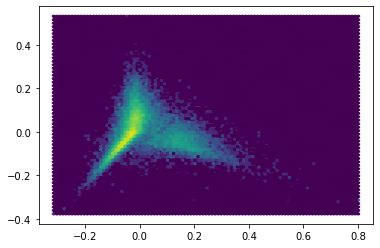

In [23]:
pca_model = PCA(n_components=2).fit_transform(x_train)
plt.hexbin(pca_model[:,0],pca_model[:,1],bins='log');

# Truncated SVD

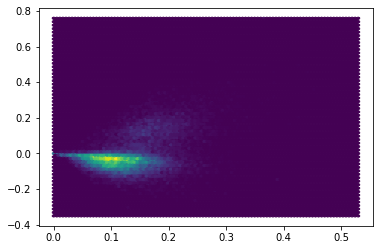

In [24]:
truncated_model = TruncatedSVD(n_components=2).fit_transform(x_train)
plt.hexbin(truncated_model[:,0],truncated_model[:,1]);